# Bloch equation with the magnetization expression from the moveable unshielded OPM self-oscillating paper

# System description

We are trying here to describe a similar system to the one present in the paper "A movable unshielded magnetocardiography system'.

The given coordinate system is given in $\begin{Bmatrix} \hat{e}_x, \hat{e}_y, \hat{e}_z \end{Bmatrix}$, with $\vec{B_0} = B_0 \hat{e}_z$, and the laser direction $\hat{n} = sin(\theta) \hat{e}_y + cos(\theta)\hat{e}_z$, the rf-field $\vec{B_1}=B_1\;\hat{n}\;cos(\omega t)$ and $\vec{M_0} = M_0 \;\hat{n}$

## Imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import *

## Constants

In [2]:
## Constants
gamma = 7e9     # Gyromagnetic ratio (Hz/T)
sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton
g_F = 0.5006
Gamma_natural = 36.10e6 #Hz
mu_eff = g_F * mu_B  # g_F depends on hyperfine level (±1/2 for Rb-87)


## Parameters
Gamma = 50e3    # Relaxation rate (Hz) ; estimated from the google colab 'Vapour cell simulation'
B_0 = 50e-6    # Static field intensity (Tesla)
B_1 = 5e-6      # RF field intensity (Tesla)
theta = 45*np.pi/180

#P_laser = np.logspace(np.log10(4e-6), np.log10(0.2e-3), num=6) # Laser power (W)
beam_diameter = 3e-3 # self-explanatory (m)

P_laser = 2e-6 #W

P = 3e4        # Cell pressure (Pa)
V = 3e-3*3e-3*1.6e-3 # Cell volume (m^3)
z_cell = 1.6e-3 # Cell length (m)
T = 273.15+80   # Cell temperature (K)

I_sat = 44.84

## Derived parameters
omega = gamma * B_0    # Frequency of the RF field (Hz)

I = P_laser/(np.pi*(beam_diameter/2)**2) # Laser intensity before the cell (W/m²)
R_op = Gamma_natural * (I)/(I+I_sat)

Gamma_tot = Gamma + R_op

Delta = omega - gamma*B_0
delta = 1/(2*np.sqrt(2)) * gamma * B_1 * np.sin(theta)

n_ideal_gas = P/(k*T)     # Rb density (m^-3)
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6 #To make it m^-3
N = P*V/(k*T) # Number of particles
M_0 = n*mu_eff      # maximum magnetization

t_span = [0, 1000/(gamma*B_0)]
sampling_rate = int(3*gamma*B_0)
t = np.linspace(t_span[0], t_span[1], sampling_rate)  

In [3]:
R_op

226364.01993878523

## Magnetization

$$M_{pump} = sin(\theta)\,M_y + cos(\theta)\,M_z$$

In [4]:
""" prefactor = 1/2 * R_op * M_0 * gamma * B_1 * np.sin(theta) * np.cos(theta)
denominator = Gamma_tot**3 + 2 * delta**2 * Gamma_tot + Delta**2 * Gamma_tot
numerator1 = Gamma_tot * np.cos(omega * t) + Delta * np.sin(omega * t)
numerator2 = Gamma_tot**2 + Delta**2

M_pump = prefactor * np.sin(theta) * (numerator1) / (denominator) + prefactor * np.cos(theta) * (numerator2)/(denominator)

M_real = M_pump 
M_real """

' prefactor = 1/2 * R_op * M_0 * gamma * B_1 * np.sin(theta) * np.cos(theta)\ndenominator = Gamma_tot**3 + 2 * delta**2 * Gamma_tot + Delta**2 * Gamma_tot\nnumerator1 = Gamma_tot * np.cos(omega * t) + Delta * np.sin(omega * t)\nnumerator2 = Gamma_tot**2 + Delta**2\n\nM_pump = prefactor * np.sin(theta) * (numerator1) / (denominator) + prefactor * np.cos(theta) * (numerator2)/(denominator)\n\nM_real = M_pump \nM_real '

In [5]:
My = R_op*M_0*delta*np.cos(theta)* (Gamma_tot * np.sin(omega * t) - Delta * np.cos(omega * t))/(Gamma_tot * (Gamma_tot**2 + Delta**2 + 2*delta**2))
Mz = R_op*M_0*np.cos(theta)* (Gamma_tot**2 + Delta**2)/(Gamma_tot * (Gamma_tot**2 + Delta**2 + 2*delta**2))

M_pump_corrected = np.sin(theta)*My + Mz*np.cos(theta)
M_real = M_pump_corrected


In [6]:
M_pump_corrected

array([2.93986381e-06, 2.93995246e-06, 2.94004111e-06, ...,
       3.01672945e-06, 3.01677941e-06, 3.01682930e-06])

In [7]:
M_0

7.19285221435674e-06

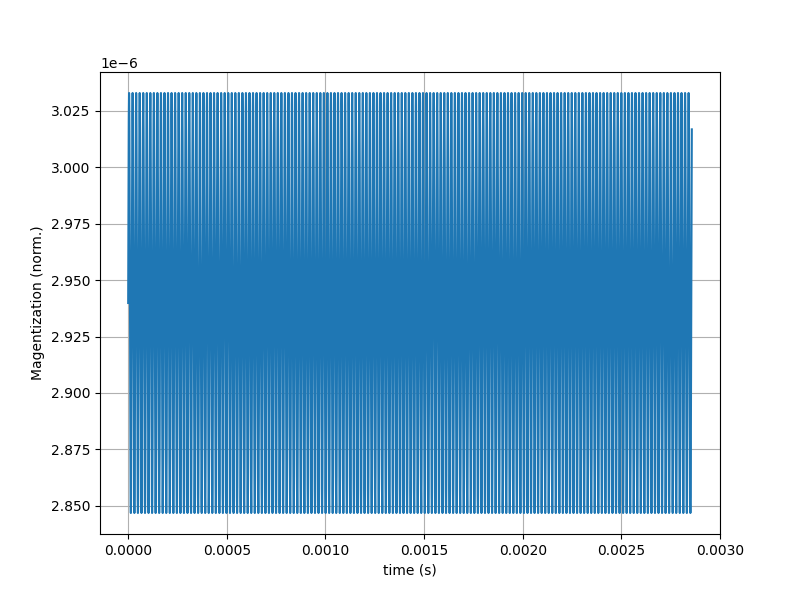

In [8]:
%matplotlib widget
fig = plt.figure(figsize=(8,6))

plt.plot(t,M_real)
plt.xlabel('time (s)')
plt.ylabel('Magentization (norm.)')
plt.grid(True)
plt.show()

## Absorption by laser

In [9]:
# Absorption coefficient
alpha_0 = n * sigma  # [1/m]

# Normalize magnetization
M0_real = n*mu_B #np.max(M_real)  # Or n * mu_eff
P_t = M_real / M_0

# Light intensity after cell (Beer-Lambert)
alpha_t = alpha_0 * (1 - P_t)  # More polarization → less absorption
I_out = I * np.exp(-alpha_t * z_cell)  # W/m²

# Total transmitted power (W)
A_beam = np.pi * (beam_diameter / 2)**2
P_out = I_out * A_beam  # W

# Photodiode current (A)
R = 0.568  # A/W
I_PD = R * P_out  # A

In [10]:
avg_alpha_t = np.mean(alpha_t)
mod_depth = np.max(alpha_t) - np.min(alpha_t)
print("Avg optical depth:", avg_alpha_t * z_cell)
print("Modulation depth in absorption (1/m):", mod_depth)

Avg optical depth: 158.59112157443946
Modulation depth in absorption (1/m): 4338.629973075367


In [11]:
P_t

array([0.40872017, 0.4087325 , 0.40874482, ..., 0.41940657, 0.41941351,
       0.41942045])

## Plot

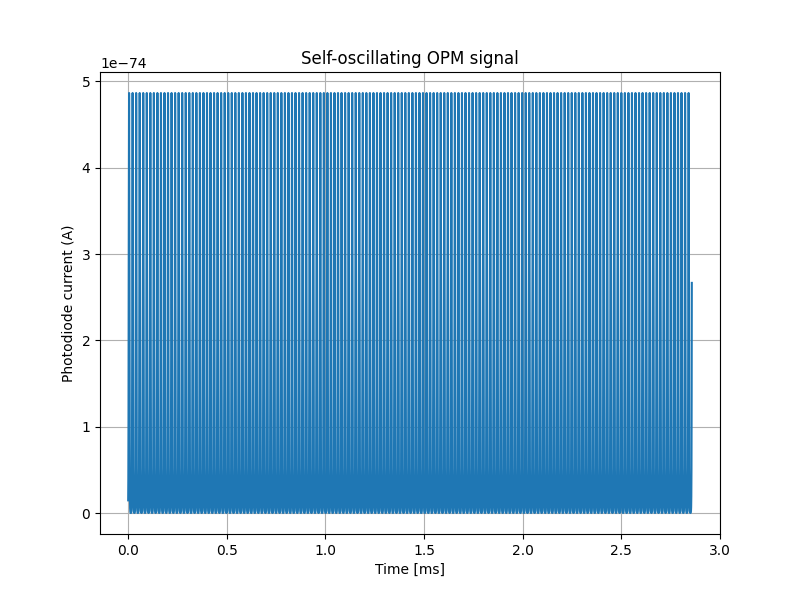

In [12]:
plt.figure(figsize=(8,6))
plt.plot(t * 1e3, I_PD)  
plt.xlabel("Time [ms]")
plt.ylabel("Photodiode current (A)")
plt.title("Self-oscillating OPM signal")
plt.grid()
plt.show()


# Sources


[1] : 'How to build a magnetometer with thermal atomic vapor: a tutorial', A. Fabricant, I. Novikova, G. Bison. <br>
[2] : 'Rubidium 87 D Line Data', Daniel A. Steck <br>
[3] : "In-situ measurement and close-loop control of atomic number density in an optically pumped magnetometer based on light absorption", ZiaoLiu et al 2023

In [13]:
rho = 2e-7
thickness = 220e-9
L = 0.018
alpha = 2000e-6 #K^-1
W = 10*thickness
Delta_T = 95-20
delta_T = 0.01

R = rho/thickness * L/W * (1 + alpha*Delta_T)
delta_R = rho/thickness * L/W * ( alpha * delta_T)

delta_R

0.14876033057851237

In [14]:
R

8553.719008264461

In [15]:
r = 3e-3
L = 2*np.pi*r

In [16]:
L

0.01884955592153876

In [17]:
220e-9*100*10

0.00021999999999999998

In [18]:
20e-6*100+220e-9*100*10

0.00222

In [19]:
from scipy.constants import Boltzmann as k_B



def rb_density(T):
    A = 26.178
    B = 4040
    log10_P_torr = A - B / T
    P_torr = 10 ** log10_P_torr
    P_Pa = P_torr * 133.322
    return P_Pa / (k_B * T)

def R_op(I):
    """
    Optical pumping rate (Hz) as a function of laser intensity (W/m^2).
    """
    return Gamma_natural * I / (I + I_sat)

# Given optimal values from earlier
T = 310
P_laser = 2e-6
B0 = 50e-6
B1 = 10e-6
theta = 45
Gamma = 50e3

# Recalculate components
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6
M0 = n * mu_eff
I = P_laser / A_beam
R_op_val = R_op(I)
Gamma_tot = Gamma + R_op_val
omega = gamma * B0
delta = (1 / (2 * np.sqrt(2))) * gamma * B1 * np.sin(theta)

# My and Mz oscillation terms (at max sin/cos = 1)
Delta = 0
My_amp = R_op_val * M0 * delta * np.cos(theta) / (Gamma_tot * (Gamma_tot**2 + 2*delta**2))
Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2) / (Gamma_tot * (Gamma_tot**2 + 2*delta**2))
M_real = np.sin(theta)*My_amp + np.cos(theta)*Mz

# Polarization
P_t = M_real / M0

# Absorption and intensity
alpha_0 = n * sigma
alpha_t = alpha_0 * (1 - P_t)
I_out = I * np.exp(-alpha_t * z_cell)
P_out = I_out * A_beam

# Photodiode current
R = 0.568  # A/W
I_PD = R * P_out


In [20]:
print("I =", I)
print('n =', n)
print("R_op =", R_op_val)
print("Gamma_tot =", Gamma_tot)
print("delta =", delta)
print("My_amp =", My_amp)
print("Mz =", Mz)
print("M_real =", M_real)
print("P_t =", P_t)
print("alpha_t =", alpha_t)
print("I_out =", I_out)
print("I_PD =", I_PD)

I = 0.28294212105225836
n = 4.51211584878576e+16
R_op = 226364.01993878523
Gamma_tot = 276364.01993878523
delta = 21058.787831676313
My_amp = 2.456666558082831e-14
Mz = 8.90996190755125e-08
M_real = 4.6806009999512684e-08
P_t = 0.2234410539463249
alpha_t = 3791.2456901015757
I_out = 0.000656553729208652
I_PD = 2.636033947887433e-09


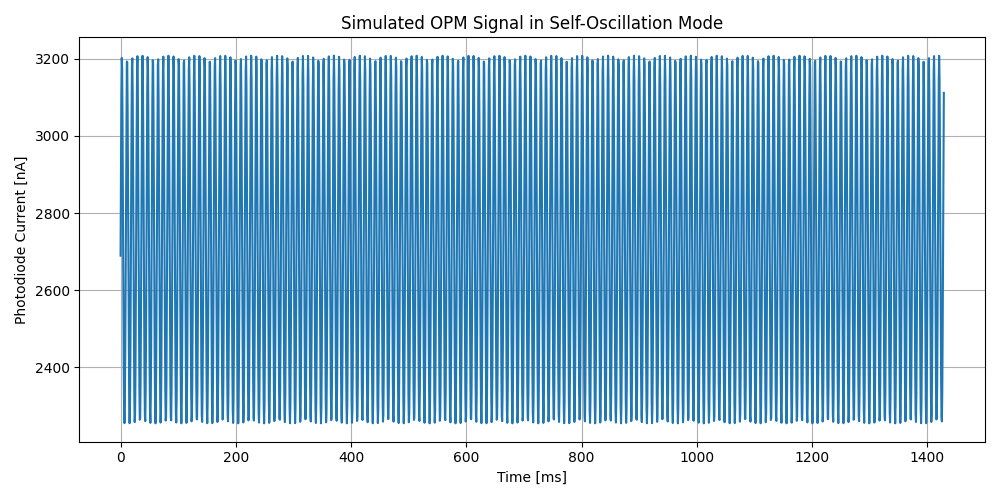

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Physical Constants ----

sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton
mu_eff = g_F * mu_B  # g_F depends on hyperfine level (±1/2 for Rb-87)
gamma = 7e9             # Gyromagnetic ratio (Hz/T)
sigma = 1.082e-13       # Absorption cross section (m²)
g_F = 0.5006
Gamma_natural = 36.10e6 # Natural linewidth (Hz)
mu_eff = g_F * mu_B     # Effective magnetic moment (J/T)

# ---- Functions ----
def rb_density(T):
    A = 26.178
    B = 4040
    log10_P_torr = A - B / T
    P_torr = 10 ** log10_P_torr
    P_Pa = P_torr * 133.322
    return P_Pa / (k_B * T)

def R_op(I):
    return Gamma_natural * I / (I + I_sat)

# ---- Experimental Parameters that works ----
""" T = 310                    # Cell temperature (K)
P_laser = 2e-6             # Laser power (W)
B0 = 50e-6                 # Static magnetic field (T)
B1 = 10e-6                 # RF magnetic field (T)
theta = np.deg2rad(45)     # Angle (rad)
Gamma = 50e3               # Spin relaxation rate (Hz)
beam_diameter = 3e-3       # Beam diameter (m)
z_cell = 1.6e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
I_sat = 44.84              # Saturation intensity (W/m²)
R = 0.568                  # Photodiode responsivity (A/W)
 """

T = 273+40                 # Cell temperature (K)
P_laser = 20e-6             # Laser power (W)
B0 = 100e-9                # Static magnetic field (T)
B1 = 100e-6                 # RF magnetic field (T)
theta = np.deg2rad(20)     # Angle (rad) between B0 (0°) and B1 (theta)
Gamma = 50e3               # Spin relaxation rate (Hz)
beam_diameter = 3e-3       # Beam diameter (m)
z_cell = 1.6e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
I_sat = 44.84              # Saturation intensity (W/m²)
R = 0.568                  # Photodiode responsivity (A/W)


# ---- Derived Quantities ----
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6                # Vapor density
M0 = n * mu_eff                  # Max magnetization
I = P_laser / A_beam             # Laser intensity
R_op_val = R_op(I)              # Optical pumping rate
Gamma_tot = Gamma + R_op_val    # Total relaxation
omega = gamma * B0              # Larmor frequency (rad/s)
delta = (1 / (2 * np.sqrt(2))) * gamma * B1 * np.sin(theta)  # RF coupling
Delta = 0                       # Resonant case

# ---- Time Vector ----
""" t_span = [0, 3*gamma*B_0]  # Simulate 5 ms
sampling_rate = 1e8
t = np.linspace(t_span[0], t_span[1], int((t_span[1] - t_span[0]) * sampling_rate)) """

t_span = [0, 1000/(omega)]
sampling_rate = int(3*omega)
t = np.linspace(t_span[0], t_span[1], sampling_rate)  

# ---- Time-Dependent Magnetization ----
My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * (Gamma_tot * np.sin(omega * t) - Delta * np.cos(omega * t)) / (Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2))
Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / (Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2))
M_real = np.sin(theta) * My + np.cos(theta) * Mz

# ---- Polarization and Detection ----
P_t = M_real / M0
alpha_0 = n * sigma
alpha_t = alpha_0 * (1 - P_t)
I_out = I * np.exp(-alpha_t * z_cell)
P_out = I_out * A_beam
I_PD = R * P_out  # Time-varying photodiode current

# ---- Plotting ----
%matplotlib widget
plt.figure(figsize=(10, 5))
plt.plot(t * 1e3, I_PD * 1e9)  # ms vs. nA
plt.xlabel("Time [ms]")
plt.ylabel("Photodiode Current [nA]")
plt.title("Simulated OPM Signal in Self-Oscillation Mode")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
print("$B_0$ =", B_0)
print('$B_1$ =', B_1)
print("R_op =", R_op_val)
print("Gamma_tot =", Gamma_tot)
print("I =", I)
print('n =', n)
print("delta =", delta)
print("My_amp =", My_amp)
print("Mz =", Mz)
print("M_real =", M_real)
print("P_t =", P_t)
print("alpha_t =", alpha_t)
print("I_out =", I_out)
print("I_PD =", I_PD)

$B_0$ = 5e-05
$B_1$ = 5e-06
R_op = 2142717.5557423877
Gamma_tot = 2192717.5557423877
I = 2.829421210522584
n = 5.958094945334039e+16
delta = 84645.66692679132
My_amp = 2.456666558082831e-14
Mz = 2.532453231178906e-07
M_real = [2.37972761e-07 2.40141278e-07 2.41826838e-07 ... 2.38070643e-07
 2.40227795e-07 2.41882722e-07]
P_t = [0.86032278 0.86816243 0.8742561  ... 0.86067664 0.86847521 0.87445813]
alpha_t = [900.45137294 849.911801   810.62803622 ... 898.17014185 847.89542854
 809.32559426]
I_out = [0.66988446 0.72630393 0.77342027 ... 0.67233399 0.72865092 0.77503369]
I_PD = [2.68955625e-06 2.91607791e-06 3.10524791e-06 ... 2.69939098e-06
 2.92550094e-06 3.11172571e-06]
